In [1]:
#configure the necessary Spark environment
import os, sys

#del os.environ['PYSPARK_SUBMIT_ARGS']

#here you should set where are located the spark files
spark_home = '/dados/app/spark-1.6.2-bin-hadoop2.6/'

os.environ["SPARK_HOME"]  = spark_home

sys.path.insert(0, spark_home + "/python")

sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.3-src.zip'))

#this defines the sparkContext sc
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.2
      /_/

Using Python version 2.7.12 (default, Jul  1 2016 15:12:24)
SparkContext available as sc, HiveContext available as sqlContext.


In [2]:
import sys, os, math, re, unicodedata
from timeit import default_timer as timer
from nltk.tag import pos_tag 
from nltk import word_tokenize
from nltk.stem.porter import *
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from pymongo import MongoClient
from bson.objectid import ObjectId
from pyspark import SparkConf, SparkContext
#from langdetect import detect
#from base import *
# encoding=utf8  

from pyspark.ml.feature import HashingTF, IDF
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.sql import Row, SQLContext
from pyspark.sql.functions import col

from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.classification import SVMWithSGD, SVMModel

def removeAccents(s):
  s = ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))
  return re.sub(r'[^\w]', ' ', s)
    
def createMongoDBConnection(host, port, username, password, db):
    client = MongoClient(host, port)
    return client[db]

def findUserById(userId):
    db = createMongoDBConnection(host, port, username, password, database)
    return db.users.find_one({'_id': ObjectId(userId)})

def findPosts(user):
    posts = []

    if user['facebook']['posts'] is not None:
        for post in user['facebook']['posts']:
            if 'message' in post.keys():
                posts.append((post['id_post'], removeAccents(post['message']), u'Post', u'Facebook'))

    if user['twitter'] is not None:
        for post in user['twitter']:
            if 'text' in post.keys():
                posts.append((post['id'], removeAccents(post['text']), u'Post', u'Twitter'))  

    return posts


def findProductById(prodId):
    db = createMongoDBConnection(host, port, username, password, database)
    prod = db.produto_novo.find_one({'_id': ObjectId(prodId)})
    prod['idprod'] = str(prod['_id'])
    return prod

def getTokensAndCategories():  
    db = createMongoDBConnection(host, port, username, password, database)
    model = db.model
    
    tokens_dict = db.model.find({"_type": "token"}).limit(1).next()
    del tokens_dict['_type']
    del tokens_dict['_id']
    del tokens_dict['_datetime']
    tokens_list = [None] * (max(tokens_dict.values()) + 1)

    for key, value in tokens_dict.iteritems():
        tokens_list[value] = key

    categories_dict = db.model.find({"_type": "category"}).limit(1).next()
    del categories_dict['_type']
    del categories_dict['_id']
    del categories_dict['_datetime']
    categories_list = [None] * (max(categories_dict.values()) + 1)

    for key, value in categories_dict.iteritems():
        categories_list[value] = key

    categories_and_subcategories_dict = db.model.find({"_type": "category and subcategory"}).limit(1).next()
    del categories_and_subcategories_dict['_type']
    del categories_and_subcategories_dict['_id']
    del categories_and_subcategories_dict['_datetime']
    categories_and_subcategories_list = [None] * (max(categories_and_subcategories_dict.values()) + 1)

    for key, value in categories_and_subcategories_dict.iteritems():
        pre_string = key.split(",")
        categories_and_subcategories_list[value] = (pre_string[0], pre_string[1])

    return tokens_list, categories_list, categories_and_subcategories_list
    

def cossine(v1, v2):
    if (v1.dot(v1)*v2.dot(v2)) != 0:
        return v1.dot(v2)/(v1.dot(v1)*v2.dot(v2))
    else:
        return 0    

In [3]:
APP_NAME = 'Recomender System - Calculo de recomendacao'
threshold  = 0.0002
numStarts = 5

host = 'localhost'
port = 27017
username = ''
password = ''
database = 'tcc-recsys-mongo'

sqlContext = SQLContext(sc)

In [4]:
def process_recomendation(iduser, check_avaliacao):
    
    user = findUserById(iduser)
    posts = findPosts(user) 

    tokens, category, categoryAndSubcategory = getTokensAndCategories()
    postsRDD = (sc.parallelize(posts).map(lambda s: (s[0], word_tokenize(s[1].lower()), s[2], s[3], s[1]))
                    .map(lambda p: (p[0], [x for x in p[1] if x in tokens] ,p[2], p[3], p[4]))
                    .cache())

    stpwrds = stopwords.words('portuguese')
    corpusRDD = (postsRDD.map(lambda s: (s[0], [PorterStemmer().stem(x) for x in s[1] if x not in stpwrds], s[2], s[3], s[4]))
                         .filter(lambda x: len(x[1]) >= 20 or (x[2] == u'Post' and len(x[1])>0))
                         .cache())
    
   
    wordsData = corpusRDD.map(lambda s: Row(label=int(s[0]), words=s[1], type=s[2], originalpost=s[4]))
    

    wordsDataDF = sqlContext.createDataFrame(wordsData).unionAll(sqlContext.read.parquet("/home/felipe/Documentos/TCC/Experimento/spark_cluster/spark-1.6.2-bin-hadoop2.6/wordsDataDF.parquet"))
    numTokens = len(tokens)
    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=numTokens)
    idf = IDF(inputCol="rawFeatures", outputCol="features")

    featurizedData = hashingTF.transform(wordsDataDF)

    idfModel = idf.fit(featurizedData)
    tfIDF = idfModel.transform(featurizedData).cache()
       
    postTFIDF = (tfIDF
                    .filter(tfIDF.type==u'Post')
                    #.map(lambda s: Row(label=s[0], type=s[1], words=s[2], rawFeatures=s[3], features=s[4], sentiment=SVM.predict(s[4])))
                    .cache())
    
    NB = NaiveBayesModel.load(sc, '/dados/models/naivebayes/modelo_categoria')
    SVM = SVMModel.load(sc, "/dados/models/svm")
    predictions = (postTFIDF
                    .map(lambda p: (NB.predict(p.features), p[0], SVM.predict(p.features), p.originalpost))
                    #.filter(lambda p: p[2]==1)
                    .map(lambda p: (p[0], (p[1], p[2], p[3])))
                    .groupByKey()
                    .mapValues(list)
                    .collect())
    
    for prediction in predictions:
        category_to_use = category[int(prediction[0])]
        for post in prediction[1]:
            post = post + (check_avaliacao,)
            sug_sentiment.append(post)           

In [5]:
#avaliacoes_feitas = []
#users = db.users.find({"avaliacoes":{"$exists":True}})
#for user in users:
    #for avaliacao in user['avaliacoes']:
        #for recomendacao in user['recomendacoes']:
            #for product_rec in recomendacao['products']:
                #if product_rec['idprod'] == avaliacao['idprod']:
                    #idpost_recomendacao =  recomendacao['postId']
                    #break
        #avaliacoes_feitas.append((idpost_recomendacao, str(user['_id'])))

In [5]:
sug_sentiment = []

db = createMongoDBConnection(host, port, username, password, database)
users = db.users.find({"recomendacoes":{"$exists":True}})
check_avaliacao = "Nao"
for user in users:
    if 'avaliacoes' in user:
        check_avaliacao = "Tem avaliacao"
    else:
        check_avaliacao = "Nao tem avaliacao"
        
    process_recomendation(user['_id'], check_avaliacao)

In [47]:
sug_sentimentRDD = sc.parallelize(sug_sentiment)
sug_sentiment_total = sug_sentimentRDD.filter(lambda x: x[3]=='Tem avaliacao').map(lambda x: (x[1], 1)).reduceByKey(lambda a,b: a+b).collect()
sug_sentiment_tnt = sug_sentimentRDD.map(lambda x: (x[3], 1)).reduceByKey(lambda a,b: a+b).collect()

In [31]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

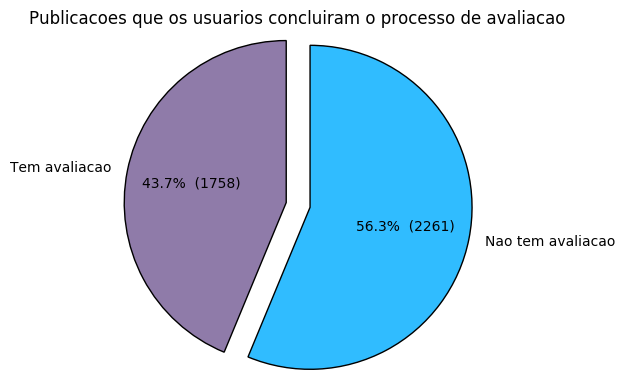

In [45]:
colors = ["#8f7ba9", "#30bcff", ]
# Create a pie chart
plt.pie(
    # using data total)arrests
    map(lambda x: x[1], sug_sentiment_tnt),
    # with the labels being officer names
    labels=map(lambda x: x[0], sug_sentiment_tnt),
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct=make_autopct(map(lambda x: x[1], sug_sentiment_total)),
    )

# View the plot drop above
plt.axis('equal')
plt.title('Publicacoes que os usuarios concluiram o processo de avaliacao')
# View the plot
plt.tight_layout()
plt.show()

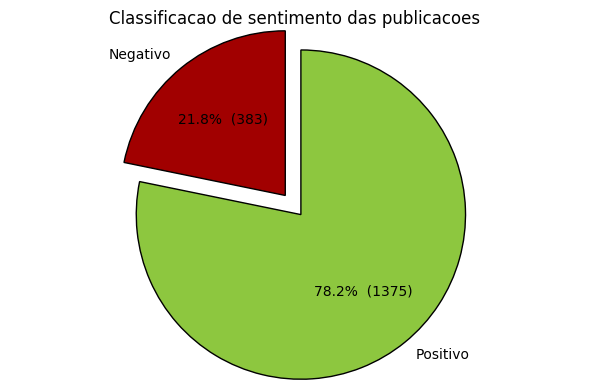

In [48]:
colors = ["#a10000", "#8dc73f", ]
# Create a pie chart
plt.pie(
    # using data total)arrests
    map(lambda x: x[1], sug_sentiment_total),
    # with the labels being officer names
    labels=map(lambda x: 'Positivo' if x[0] == 1 else 'Negativo', sug_sentiment_total),
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out}
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct=make_autopct(map(lambda x: x[1], sug_sentiment_total)),
    )

# View the plot drop above
plt.axis('equal')
plt.title('Classificacao de sentimento das publicacoes')
# View the plot
plt.tight_layout()
plt.show()

In [25]:
print sug_sentimentRDD.filter(lambda x: x[3] == 'Tem avaliacao').count()
print sug_sentimentRDD.filter(lambda x: x[3] == 'Nao tem avaliacao').count()

1758
2261


In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


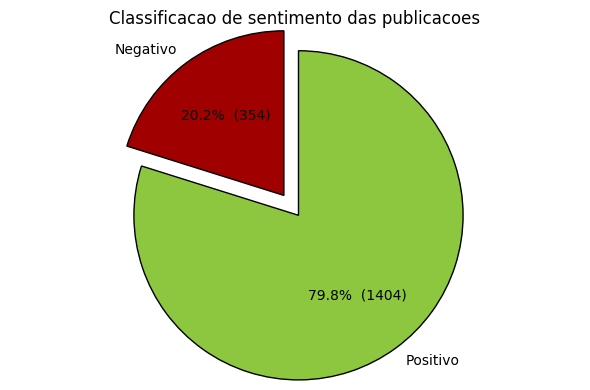

In [26]:
colors = ["#a10000", "#8dc73f", ]
# Create a pie chart
plt.pie(
    # using data total)arrests
    map(lambda x: x[1], sug_sentiment_total),
    # with the labels being officer names
    labels=map(lambda x: 'Positivo' if x[0] == 1 else 'Negativo', sug_sentiment_total),
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct=make_autopct(df['n']),
    )

# View the plot drop above
plt.axis('equal')
plt.title('Classificacao de sentimento das publicacoes')
# View the plot
plt.tight_layout()
plt.show()

In [56]:
print sug_sentimentRDD.filter(lambda x: x[3]=='Tem avaliacao' and x[1]==0).take(100)

[(u'2', 0, u'Coca com Diamante Negro  QUE DELISIA', 'Tem avaliacao'), (u'7', 0, u'A realidade dessa vida  Rossi', 'Tem avaliacao'), (u'8', 0, u'Just a realidade  10de sempre fazendo dietinha', 'Tem avaliacao'), (u'12', 0, u'Normalmente quem publica esse tipo de coisa e a minha mae  mas essa parada e DAZORA ', 'Tem avaliacao'), (u'30', 0, u'E que venham Mazinhas cada vez melhores   ', 'Tem avaliacao'), (u'38', 0, u'Vamos assinar ', 'Tem avaliacao'), (u'3', 0, u'Let s keep cooking     ', 'Tem avaliacao'), (u'13', 0, u'Jesus Christ ', 'Tem avaliacao'), (u'12', 0, u'E trub  um smile  o geleia do caca fantasma ou um esboco de um tartaruga ninja    ', 'Tem avaliacao'), (u'18', 0, u'Maior ensinamento de 2016', 'Tem avaliacao'), (u'23', 0, u'Eu tentando sair ilesa desse 2016', 'Tem avaliacao'), (u'25', 0, u'As maiores rainhas funkeiras que voce respeita  ', 'Tem avaliacao'), (u'56', 0, u'Tem dias que a vida e um ato de coragem   ', 'Tem avaliacao'), (u'13', 0, u'I m learning to walk again  I b

In [59]:
(1-0.8026)*383

75.6042

In [80]:
users = db.users.find({"avaliacoes":{"$exists":True}})
num_posts = []
for user in users:
    posts = findPosts(user) 
    num_posts.append(len(posts))

In [81]:
import numpy as np
print np.mean(num_posts)
print np.std(num_posts)

33.515625
39.4291263644


In [79]:
307+76

383

In [83]:
float(76)/64

1.1875